# Twitterでフォロワーをクラスタリングしてみた。
---

### 使うライブラリ
networkx, pandas, matplotlib

## 目次
- クラスタリングに必要なデータとは、
- クラスタリングをするために必要な手順（ライブラリや、データ整形など）
- 結果見る
- 結果をDB情報から引っ張ってきてさらにみて見る。
- 結果を元に、クラスタの属性分析をする方向性を固める。
    - 今のところ、自己紹介文を使って、tf-idfで処理し、属性を表す単語をピックアップする予定。
- 属性分析

## クラスタリングに必要なデータとは。
簡単にまとめると、  
ノードとエッジのみ。

今回の場合は、  
ノード = フォロワー（twitterユーザー）  
エッジ = 繋がりの関係（誰が誰をフォローしているのかということ）

ちょっとしたデモやる

In [1]:
import os, sys
sys.path.append('..')

import json
import time
import random
from tqdm import tqdm

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# グラフの定義
G = nx.DiGraph()

In [3]:
# エッジの追加
G.add_node(1)

In [4]:
# エッジの追加。存在しないノードは勝手に作ってくれる。
G.add_edge(2, 3)

In [5]:
# 存在するノードの確認
G.nodes()

NodeView((1, 2, 3))

In [6]:
# 存在するエッジの確認
G.edges()

OutEdgeView([(2, 3)])

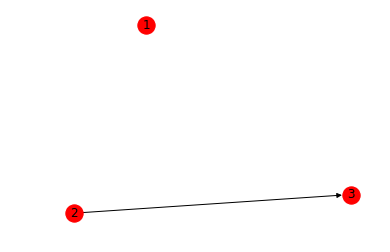

In [7]:
plt.figure(figsize=(6,4))
pos = nx.spring_layout(G) # グラフにラベルつける。
nx.draw_networkx(G, pos)
plt.axis("off")
plt.show()

## クラスタリングをするために必要な手順（ライブラリや、データ整形など）
__ライブラリ__  
ライブラリは前述したものを参考に。  

__データ__  
- twitterのuser_idをひとまず、ノードの判別に利用する。
- フォロワーがフォローしているユーザー群を持ってきて、フォロワーに含まれるuser_idを取得  
イメージ  
```
dict = {ユーザーA: [B, C, D, F], ユーザーB: [A, D, E], ...}
```

In [8]:
from functions import twitter

In [9]:
with open('../data/key.json') as f:
    keys = json.load(f)

tw = twitter(keys)

In [10]:
# まず、自分のフォロワーを取得
my_followers = tw.getFollowerIds(screen_name='rui_308')

totalGetFollowerNum: 4301


フォローしている人リストを取得するいは、スクリーンネームが必要っぽい。本当かはわからない。  

ひとまず、フォロワーの情報を集めることに。

In [11]:
# 初回のみ

# # データベース操作用
# from db import psql_save

# psql = psql_save()
# # テーブルの作成
# psql.recreate_tables()

In [14]:
# idリストからユーザー情報の取得
tw.getUserInfo(query_screen_name='rui_308', ids=my_followers)

### DBからpandas.DataFrameに代入 

In [39]:
import pandas as pd
import psycopg2

# 接続情報
connection_config = {
    'host': 'localhost',
    'port': '5432',
    'database': 'my_db',
    'user': 'rui',
    'password': 'password'
}

# 接続
connection = psycopg2.connect(**connection_config)

In [40]:
df = pd.read_sql(sql="SELECT * FROM twitter.follower_user_info;", con=connection)

In [41]:
df.head()

,slave_screen_name,user_id,screen_name,friends_count,followers_count,self_discription
0,rui_308,975291049991069696,chikuwa_ny,100,18,邦ロック垢🎸 KEYTALK、フォーリミ 、マイヘア、オーラル、夜ダンなど好きです！よろしく...
1,rui_308,1009352436811644928,bot31744407,150,20,たくさんのバンドや音楽を知っていれば周りからも注目され、作曲する際にもたくさんの引き出しを持...
2,rui_308,913026982115344389,haru_shumi_2,882,244,nana民2017.11.20〜 フォローお願いします┏○))低音練習中！[コラボしませんか...
3,rui_308,974589299315191808,Xxx__xxX_xxXxx,349,211,邦ロックがすき ☺💓 無言フォローすみません💦
4,rui_308,2874972216,kiske_PR,18031,16723,これからオリジナル曲やカバーしてみた動画をあげていきます！\n\n気に入った曲いいねする\n...


In [60]:
len(df)

4301

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x151b34e080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x151b3fc278>]], dtype=object)

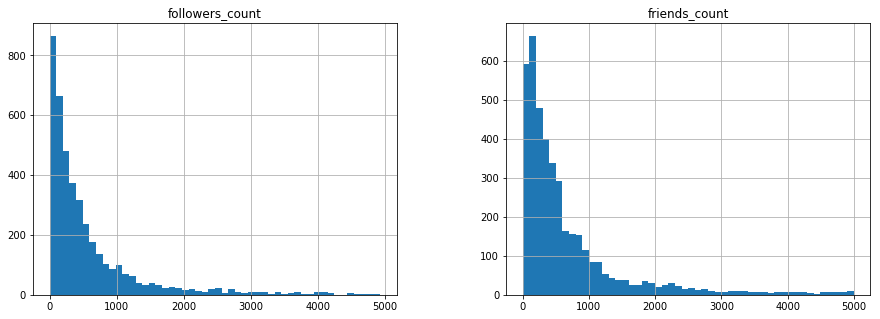

In [59]:
max_count = 5000

df.loc[(df.friends_count<max_count) & (df.followers_count<max_count), ['friends_count', 'followers_count']].hist(bins=50, figsize=(15,5))

In [74]:
test_df = df[(400<df.friends_count) & (df.friends_count<500)]

In [75]:
len(test_df)

334

In [78]:
ids = test_df.user_id
names = test_df.screen_name

In [77]:
dict_connection = {}

for user_id, screen_name in tqdm(zip(ids, names), total=len(ids)):
    target_ids = tw.getFriendIds(screen_name)
    dict_connection[user_id] = target_ids
    time.sleep(10*random.uniform(0.5,1.5))

  0%|          | 0/5 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [73]:
dict_connection

{2874972216: [980615174175449088,
  987231568182657024,
  927531446503219200,
  849118625696858112,
  908950344079622144,
  2297690713,
  939458044416499712,
  1009001854770954240,
  791521774781378560,
  817917662432894977,
  904357252437426178,
  834051664260714498,
  914827063206354946,
  760709480728453120,
  818748433758420992,
  950005612787593216,
  897838718987390978,
  786477028971118592,
  837278869820334080,
  2302987579,
  942258694980493313,
  904242911499378688,
  772223151241428992,
  964784033434497024,
  993149491569045504,
  992622688303661058,
  759763885553356801,
  879601859102523392,
  566413963,
  860443965778153473,
  936582153445376000,
  983187895077945345,
  944513389035896832,
  4286090113,
  931013027817709568,
  1850999797,
  885825400047255552,
  868338451191537664,
  877090819873755138,
  3002621882,
  945085397746384896,
  794702526649991168,
  2264422178,
  3145665278,
  910968205648080897,
  610344693,
  834036858732507137,
  927811371139440641,
  934